# Avito Challenge: Stage 2v1 Model
This Stage 2v1 Model also draws inspiration from a public kernel (https://www.kaggle.com/tunguz/bow-meta-text-and-dense-features-lb-0-2241/code). In this model builds on top of 2v0 with a TFIDF component and text meta-features.

In [1]:
import pandas as pd
import numpy as np
import os
import json
import pickle
import nltk
from nltk.corpus import stopwords

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score

from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import FeatureUnion

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from scipy.sparse import hstack, csr_matrix

import lightgbm as lgb

In [2]:
import sys
reload(sys)
sys.setdefaultencoding('utf8')

In [3]:
# Load parameters file
with open('setup_param.json', 'r') as handle:
    setup_params = json.load(handle)

In [29]:
parent_path = setup_params['parent_dir']
data_path = setup_params['data_dir']
scripts_path = setup_params['scripts_dir']
train_csv_path = setup_params['train_csv']
test_csv_path = setup_params['test_csv']

# Training and test metadata
labels_path = setup_params['train_labels']
test_items_path = setup_params['test_items']

model_path_2 = setup_params['model_dir_2']

## Loading Data Stage:

In [5]:
# Original training and test dataframes
training = pd.read_csv(train_csv_path, index_col='item_id', parse_dates=['activation_date'])
traindex = training.index
testing = pd.read_csv(test_csv_path, index_col='item_id', parse_dates=['activation_date'])
testdex = testing.index

In [6]:
y = training.deal_probability.copy()

In [7]:
training.drop("deal_probability",axis=1, inplace=True)

In [8]:
print('Train shape: {} Rows, {} Columns'.format(*training.shape))
print('Test shape: {} Rows, {} Columns'.format(*testing.shape))

## Combining Train and Test:

In [9]:
df = pd.concat([training, testing], axis=0)
print('All data shape: {} Rows, {} Columns'.format(*df.shape))

## Feature Engineering:

In [10]:
df['price'] = np.log(df['price'] + 0.001)
df['price'].fillna(-999, inplace=True)
df['image_top_1'].fillna(-999, inplace=True)

In [11]:
# Create time variables
df['Weekday'] = df['activation_date'].dt.weekday
df['Week of Year'] = df['activation_date'].dt.week
df['Day of Month'] = df['activation_date'].dt.day
df.drop(['activation_date', 'image'], axis=1, inplace=True)

In [12]:
# Encode variables
categorical = ["user_id","region","city","parent_category_name","category_name","user_type","image_top_1"]
lbl = LabelEncoder()
for col in categorical:
    df[col] = lbl.fit_transform(df[col].astype(str))

### Text Features:

In [13]:
df['text_feat'] = df.apply(lambda row: ' '.join([str(row['param_1']), str(row['param_2']), str(row['param_3'])]), 
                           axis=1)
df.drop(['param_1', 'param_2', 'param_3'], axis=1, inplace=True)

In [14]:
# Meta text features
textfeats = ['description', 'text_feat', 'title']
for cols in textfeats:
    df[cols] = df[cols].astype(str)
    df[cols] = df[cols].astype(str).fillna('highscoreftw')
    df[cols] = df[cols].str.lower()
    df[cols + '_num_chars'] = df[cols].apply(len)
    df[cols + '_num_words'] = df[cols].apply(lambda comment: len(comment.split()))
    df[cols + '_num_unique_words'] = df[cols].apply(lambda comment: len(set(w for w in comment.split())))
    df[cols + '_words_vs_unique'] = df[cols + '_num_unique_words'] / df[cols + '_num_words'] * 100

In [15]:
# TFIDF Stage
russian_stop = set(stopwords.words('russian'))

In [16]:
# Resolve unicode decoding errors
for cols in textfeats:
    df[cols] = df[cols].str.decode('utf8')

In [17]:
tfidf_para = {
    'stop_words': russian_stop,
    'analyzer': 'word',
    'token_pattern': r'\w{1,}', 
    'sublinear_tf': True,
    'dtype': np.float32,
    'norm': 'l2',
    'smooth_idf': False,
    'strip_accents': 'unicode', 
    'encoding': 'utf8',
    'decode_error': 'ignore'
}

In [18]:
# Function for overriding preprocessing (string transformation)
def get_col(col_name): return lambda x: x[col_name]

In [19]:
vectorizer = FeatureUnion([
    ('description', TfidfVectorizer( 
        max_features=16000,
        ngram_range = (1, 2),
        preprocessor=get_col('description'),
        **tfidf_para)),
    ('text_feat', CountVectorizer(
        ngram_range=(1, 2),
        decode_error = 'ignore',
        preprocessor=get_col('text_feat'))),
    ('title', TfidfVectorizer(
        ngram_range = (1, 2),
        preprocessor=get_col('title'),
        **tfidf_para))
])

In [20]:
vectorizer.fit(df.loc[traindex, :].to_dict('records'))
ready_df = vectorizer.transform(df.to_dict('records'))
tfvocab = vectorizer.get_feature_names()

In [21]:
# Drop text columns
df.drop(textfeats, axis=1, inplace=True)

## Modeling Stage:

In [22]:
# Combine dense features with sparse text bag of words features
X = hstack([csr_matrix(df.loc[traindex, :].values), ready_df[0:traindex.shape[0]]])  # Sparse matrix
testing = hstack([csr_matrix(df.loc[testdex, :].values), ready_df[traindex.shape[0]:]])
tfvocab = df.columns.tolist() + tfvocab
for shape in [X,testing]:
    print("{} Rows and {} Cols".format(*shape.shape))
print("Feature Names Length: ",len(tfvocab))

In [23]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.10, random_state=23)

In [24]:
lgbm_params =  {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'max_depth': 15,
    'num_leaves': 37,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.8,
    'learning_rate': 0.19,
    'verbose': 1
}

In [25]:
# LGBM Dataset Formatting 
lgtrain = lgb.Dataset(X_train, y_train, feature_name=tfvocab, categorical_feature = categorical)
lgvalid = lgb.Dataset(X_valid, y_valid, feature_name=tfvocab, categorical_feature = categorical)

In [26]:
lgb_clf = lgb.train(
    lgbm_params,
    lgtrain,
    num_boost_round=1600,
    valid_sets=[lgtrain, lgvalid],
    valid_names=['train','valid'],
    early_stopping_rounds=200,
    verbose_eval=200
)

Text(0.5,1,u'Light GBM Feature Importance')

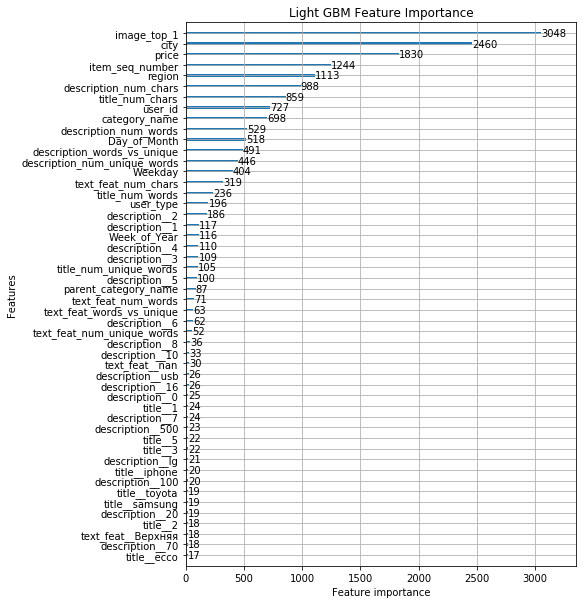

In [27]:
# Feature Importance Plot
f, ax = plt.subplots(figsize=[7,10])
lgb.plot_importance(lgb_clf, max_num_features=50, ax=ax)
plt.title("Light GBM Feature Importance")

In [30]:
print "Model Evaluation Stage"
print 'RMSE:', np.sqrt(mean_squared_error(y_valid, lgb_clf.predict(X_valid)))

submission_path = model_path_2 + 'tfidf_lgb.csv'
lgpred = lgb_clf.predict(testing)
lgsub = pd.DataFrame(lgpred, columns=["deal_probability"], index=testdex)
lgsub['deal_probability'].clip(0.0, 1.0, inplace=True)  # Between 0 and 1
lgsub.to_csv(submission_path, index=True, header=True)